# Deep Learning & Art: Neural Style Transfer

This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using the algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [6]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

# load parameters from VGG model.

In [7]:
# Load model and display all tensor layers.
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
for k, v in model.items():
    print(k, v)

input <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>
conv1_1 Tensor("Relu_16:0", shape=(1, 300, 400, 64), dtype=float32)
conv1_2 Tensor("Relu_17:0", shape=(1, 300, 400, 64), dtype=float32)
avgpool1 Tensor("AvgPool_5:0", shape=(1, 150, 200, 64), dtype=float32)
conv2_1 Tensor("Relu_18:0", shape=(1, 150, 200, 128), dtype=float32)
conv2_2 Tensor("Relu_19:0", shape=(1, 150, 200, 128), dtype=float32)
avgpool2 Tensor("AvgPool_6:0", shape=(1, 75, 100, 128), dtype=float32)
conv3_1 Tensor("Relu_20:0", shape=(1, 75, 100, 256), dtype=float32)
conv3_2 Tensor("Relu_21:0", shape=(1, 75, 100, 256), dtype=float32)
conv3_3 Tensor("Relu_22:0", shape=(1, 75, 100, 256), dtype=float32)
conv3_4 Tensor("Relu_23:0", shape=(1, 75, 100, 256), dtype=float32)
avgpool3 Tensor("AvgPool_7:0", shape=(1, 38, 50, 256), dtype=float32)
conv4_1 Tensor("Relu_24:0", shape=(1, 38, 50, 512), dtype=float32)
conv4_2 Tensor("Relu_25:0", shape=(1, 38, 50, 512), dtype=float32)
conv4_3 Tensor("Relu_26:0", shap

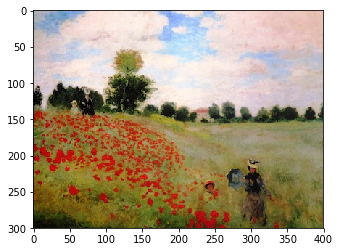

In [8]:
content_image = scipy.misc.imread("images/monet.jpg")
imshow(content_image)

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [9]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost from formula above.
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C), shape=(n_C, -1))
    a_G_unrolled = tf.reshape(tf.transpose(a_G), shape=(n_C, -1))
    
    # compute the cost with tensorflow
    J_content = tf.multiply((1/(4*n_H*n_W*n_C)),
                            tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))))
    
    return J_content

# Computing Style Cost

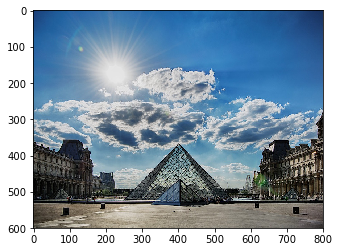

In [10]:
style_image = scipy.misc.imread("images/louvre.jpg")
imshow(style_image)

# Calculate Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

In [11]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

In [12]:
def compute_layer_style_cost(a_S, a_G):
    """
    Compute style cost from formula above.
    
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))  # the values in the shape are no longer tensors.
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2))) * tf.reduce_sum(tf.square((tf.subtract(GS, GG))))

    
    return J_style_layer

# Style Weights

In [13]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

In [14]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function above.
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

In [16]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [17]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [18]:
style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

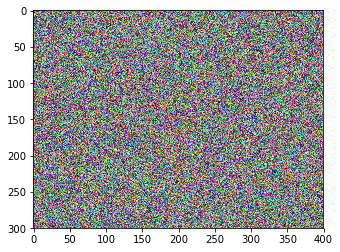

In [19]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [20]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
model

{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 

In [21]:
# Assign the content image to be the input of the VGG model
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2. 
out = model['conv4_2']

# Runs the tensor so you get the activation ouput values.
a_C = sess.run(out)

# Set a_G to be the hidden layer activaiton from the same layer. a_G references model['conv4_2']
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that when we 
# run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost. Returns a tensor.
J_content = compute_content_cost(a_C, a_G)

In [22]:
# Assign the input of the model to be the "style" image
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [23]:
# computer total cost
J = total_cost(J_content, J_style, alpha=10, beta=40)

In [24]:
## define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [25]:
def model_nn(sess, input_image, num_iterations = 200):
    # Initialize gloabal variables.
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image(initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        # Run the session on the train_step to minimize the total cost.
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # Save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
            
        # Save last generated image
        save_image('output/generated_image.jpg', generated_image)
        
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.0494e+09
content cost = 7856.7
style cost = 1.26233e+08


You're done! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image!